Group 12 </br>
Harinarayan J (23110128) and Vyomika Vasireddy (23110363) </br>
Lab - 7

### 1. Dataset Preparation

In [4]:
!curl https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv -o train.tsv 
!curl https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv -o test.tsv 
!curl https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv -o imdb.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  703k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  703k  100  703k    0     0   477k      0  0:00:01  0:00:01 --:--:--  477k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 94  184k   94  174k    0     0   151k      0  0:00:01  0:00:01 --:--:--  151k
100  184k  100  184k    0     0   160k      0  0:00:01  0:00:01 --:--:--  160k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
# Data preparation for first dataset
train = pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test.tsv", sep="\t")

X = train.iloc[:, 0]
Y = train.iloc[:, 1]

X_t = test.iloc[:, 0]
Y_t = test.iloc[:, 1]

X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [3]:
print(X_tr.shape, X_val.shape, X_t.shape)
print(Y_tr.shape, Y_val.shape, Y_t.shape)

(5535,) (1384,) (1820,)
(5535,) (1384,) (1820,)


### 2. Multi-Layer Perceptron Model

In [4]:
# Imports

import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer, AutoModel

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# MLP Class with hidden sizes [512, 256, 128, 64] 

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.l1 = nn.Linear(10000, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)

        self.o = nn.Linear(64, 2)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.dropout(x)
        x = self.activation(self.l2(x))
        x = self.dropout(x)
        x = self.activation(self.l3(x))
        x = self.dropout(x)
        x = self.activation(self.l4(x))
        x = self.o(x)
        return x

In [53]:
# Initialize model and print summary
model = MLP().to(device)
print(model)
summary(model, (1, 10000))

MLP(
  (l1): Linear(in_features=10000, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=64, bias=True)
  (o): Linear(in_features=64, out_features=2, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       5,120,512
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 256]         131,328
              ReLU-5               [-1, 1, 256]               0
           Dropout-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 128]          32,896
              ReLU-8               [-1, 1, 128] 

In [54]:
# Criterion and Optim

criterion = CrossEntropyLoss()
op = Adam(model.parameters(), lr=0.0001)

### 3. Case 1: Bag of Words

In [55]:
# Imports 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import pickle
import gzip

from tqdm.notebook import tqdm

In [56]:
# Saving the checkpoint using pickle and gzip

def checkpoint(model, path):
    c = {"model_state" : model.state_dict()}
    with gzip.open(path, "wb") as f:
        pickle.dump(c, f)
    print("Checkpoint saved at", path)
    

In [57]:
# Loading the checkpoint

def load(model, path):
    with gzip.open(path, "rb") as f:
        c = pickle.load(f)
    model.load_state_dict(c["model_state"])
    print("Checkpoint loaded from", path)

In [58]:
# Creating a vectorizer

vec = CountVectorizer(max_features=10000)
X_tr_v = vec.fit_transform(X_tr)
X_val_v = vec.transform(X_val)
X_t_v = vec.transform(X_t)

In [59]:
# Checking the sizes of the vectors

print(X_tr_v.shape, X_val_v.shape, X_t_v.shape)

(5535, 10000) (1384, 10000) (1820, 10000)


In [60]:
# Tensors for Model Training

X_tr_ten = torch.tensor(X_tr_v.toarray(), dtype=torch.float32).to(device)
X_val_ten = torch.tensor(X_val_v.toarray(), dtype=torch.float32).to(device)

Y_tr_ten = torch.tensor(Y_tr.to_numpy(), dtype=torch.long).to(device)
Y_val_ten = torch.tensor(Y_val.to_numpy(), dtype=torch.long).to(device)

tr_data = TensorDataset(X_tr_ten, Y_tr_ten)
val_data = TensorDataset(X_val_ten, Y_val_ten)

tr_load = DataLoader(tr_data, batch_size=32, shuffle=True)
val_load = DataLoader(val_data, batch_size=32, shuffle=False)

In [61]:
# Model Training for 10 epochs

best_acc = float(0)
tr_loss = []
val_loss = []
val_acc = []

writer = SummaryWriter()

for e in range(10):

    model.train()
    loss = 0

    for X_b, Y_b in tqdm(tr_load, desc="Epoch " + str(e + 1) + " Training"):
        
        op.zero_grad()
        out = model(X_b)
        loss_ = criterion(out, Y_b)
        loss_.backward()
        op.step()
        loss += loss_.item()
    loss /= len(tr_load)

    tr_loss.append(loss)


    model.eval()

    v_loss = 0.0
    pr, t = [], []
    
    with torch.no_grad():
        for X_b, Y_b in tqdm(val_load, desc="Epoch " + str(e + 1) + " Validation"):
            out = model(X_b)
            v_loss_ = criterion(out, Y_b)
            v_loss += v_loss_.item()

            pr.extend(torch.argmax(out, 1).cpu().numpy())
            t.extend(Y_b.cpu().numpy())

    v_loss /= len(val_load)
    val_loss.append(v_loss)
    val_acc_ = accuracy_score(t, pr)
    val_acc.append(val_acc_)

    print("Epoch", e + 1, "Training Loss", loss, "Validation Loss", v_loss, "Validation Accuracy", val_acc_)

    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(str(name)+"/weights", param.data, e)
            writer.add_histogram(str(name)+"/grad", param.grad, e)

    if val_acc_ > best_acc:
        best_acc = val_acc_
        checkpoint(model, "best_checkpoint.json.gz")
        print("Best Model Saved with Accuracy", best_acc)
    
    if e % 5 == 0:
        checkpoint(model, "checkpoint_" + str(e) + ".json.gz")
        print("Checkpoint saved at", "checkpoint_" + str(e) + ".json.gz")
    
writer.close()

Epoch 1 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.6914151086972627 Validation Loss 0.6839711639014158 Validation Accuracy 0.528179190751445
Checkpoint saved at best_checkpoint.json.gz
Best Model Saved with Accuracy 0.528179190751445
Checkpoint saved at checkpoint_0.json.gz
Checkpoint saved at checkpoint_0.json.gz


Epoch 2 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.5475108723419939 Validation Loss 0.4727007340301167 Validation Accuracy 0.7738439306358381
Checkpoint saved at best_checkpoint.json.gz
Best Model Saved with Accuracy 0.7738439306358381


Epoch 3 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.2441653710913796 Validation Loss 0.49506785652854224 Validation Accuracy 0.7904624277456648
Checkpoint saved at best_checkpoint.json.gz
Best Model Saved with Accuracy 0.7904624277456648


Epoch 4 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.0982909778811339 Validation Loss 0.6427108123898506 Validation Accuracy 0.7817919075144508


Epoch 5 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5 Training Loss 0.044773869846296104 Validation Loss 0.7745445377447389 Validation Accuracy 0.7882947976878613


Epoch 6 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6 Training Loss 0.021712356267195476 Validation Loss 0.8721088922836564 Validation Accuracy 0.7825144508670521
Checkpoint saved at checkpoint_5.json.gz
Checkpoint saved at checkpoint_5.json.gz


Epoch 7 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7 Training Loss 0.01107389804660854 Validation Loss 0.9894186495379969 Validation Accuracy 0.7839595375722543


Epoch 8 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8 Training Loss 0.006615006636405589 Validation Loss 1.1365862678397785 Validation Accuracy 0.7789017341040463


Epoch 9 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9 Training Loss 0.003940660559142956 Validation Loss 1.149228889833797 Validation Accuracy 0.7846820809248555


Epoch 10 Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10 Training Loss 0.0038258633067437065 Validation Loss 1.3814841170202603 Validation Accuracy 0.7687861271676301


In [64]:
import tensorboard
tensorboard.notebook.start("--logdir runs --port 6007")


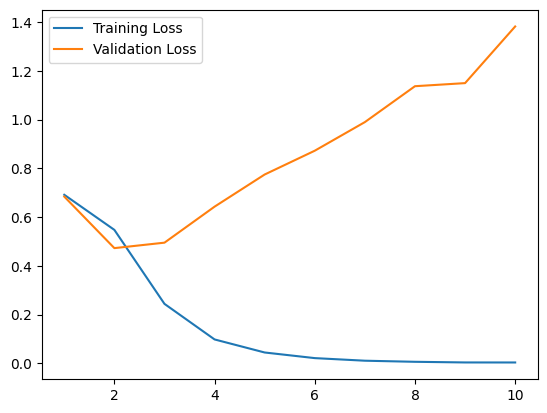

In [63]:
# Plotting the losses

epochs = range(1, 11)
plt.plot(epochs, tr_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()

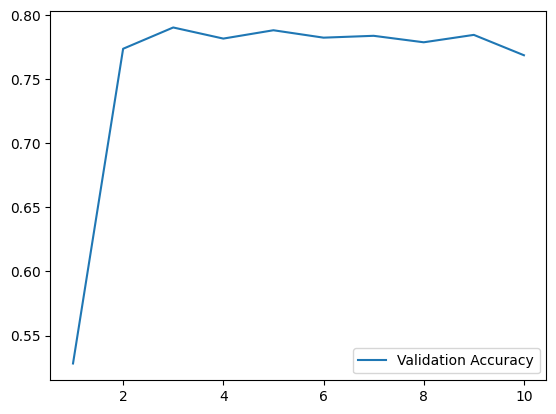

In [65]:
# Plot validation accuracy
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.show()

In [89]:
print(len(Y_t), len(pr))

1820 1384


In [93]:
# Metrics

print("Accuracy Score:", accuracy_score(t, pr))
print("F1 Score:", f1_score(t, pr))
print("Precision Score:", precision_score(t, pr))
print("Recall Score:", recall_score(t, pr))


Accuracy Score: 0.7687861271676301
F1 Score: 0.7984886649874056
Precision Score: 0.7397899649941657
Recall Score: 0.8673050615595075


<Axes: >

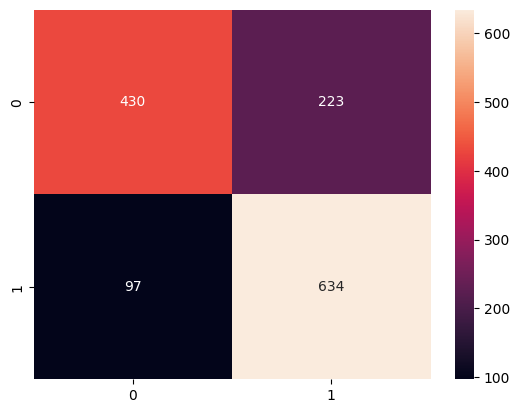

In [95]:
# Confusion Matrix

import seaborn as sns
cm = confusion_matrix(t, pr)

sns.heatmap(cm, annot=True, fmt="d")

### Using Bert Embeddings

In [125]:
# Embeddings

def bert_embed(text):
    encoded = DistilBertTokenizer.from_pretrained("distilbert-base-uncased").encode(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        out = DistilBertModel.from_pretrained("distilbert-base-uncased")(encoded)
    em = out.last_hidden_state.mean(1)
    return em

In [70]:
# Second MLP

class MLP_(nn.Module):
    def __init__(self, input_size = 768):
        super(MLP_, self).__init__()

        self.l1 = nn.Linear(input_size, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)

        self.o = nn.Linear(64, 2)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.dropout(x)
        x = self.activation(self.l2(x))
        x = self.dropout(x)
        x = self.activation(self.l3(x))
        x = self.dropout(x)
        x = self.activation(self.l4(x))
        x = self.o(x)
        return x

In [68]:
# Text Dataset Class

class TextDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        t = self.text[idx]
        l = self.label[idx]

        return t, l

In [71]:
# Initializing the model
model_ = MLP_().to(device)
op = Adam(model_.parameters(), lr=0.0001)


In [80]:
# Tensors

X_tr_txt = X_tr.to_list()
X_val_txt = X_val.to_list()

y_tr_ten = torch.tensor(Y_tr.to_numpy(), dtype=torch.long).to(device)
y_val_ten = torch.tensor(Y_val.to_numpy(), dtype=torch.long).to(device)

In [74]:
bert_embed(X_tr_txt[0])

tensor([[ 1.7363e-01, -7.3020e-02,  7.9727e-02, -1.1769e-01, -5.4779e-02,
         -2.6639e-01,  2.3995e-01,  2.2616e-01,  5.9893e-02, -1.2848e-01,
          1.8453e-01, -2.3025e-01, -1.0958e-01,  2.5087e-01, -4.2392e-01,
         -1.4698e-01,  2.1743e-01, -2.3581e-01,  1.6259e-02, -8.3266e-02,
          1.0830e-01, -1.7699e-01, -3.4129e-02,  1.6071e-01, -3.2052e-02,
         -6.2751e-02, -8.4661e-02,  1.2655e-01,  3.0783e-02, -2.0380e-01,
          4.5399e-01, -2.0657e-01, -2.4363e-01,  1.6648e-01, -2.2876e-01,
         -6.2244e-02, -5.7943e-02, -4.9208e-03, -5.3575e-01,  8.4436e-04,
         -3.4112e-01, -2.8375e-01, -6.7059e-02,  2.1959e-01, -1.3475e-01,
         -3.2999e-01, -6.0067e-02,  3.6911e-01,  1.4362e-01, -4.8068e-01,
          1.0345e-01,  1.8142e-01,  2.6080e-01,  9.7578e-03,  9.9398e-02,
          4.7362e-01, -1.1378e-01, -2.4471e-02, -1.7378e-01, -9.5165e-02,
          7.5209e-02, -4.0315e-02,  1.5088e-01, -2.1539e-01, -1.0878e-02,
          4.3284e-01, -9.2882e-02,  1.

In [ ]:
# Text to vectors

# Randomly selecting 160 samples for training and 32 testing since compute constraints
import random
random.sample(range(0, len(X_tr_txt)), 200)
random.sample(range(0, len(X_val_txt)), 32)

X_tr_txt = [X_tr_txt[i] for i in random.sample(range(0, len(X_tr_txt)), 160)]
X_val_txt = [X_val_txt[i] for i in random.sample(range(0, len(X_val_txt)), 32)]

X_tr_ten = []
X_val_ten = []

for i in tqdm(X_tr_txt, desc="Embedding Training"):
    X_tr_ten.append(torch.tensor(bert_embed(i)).to(device))

for i in tqdm(X_val_txt, desc="Embedding Validation"):
    X_val_ten.append(torch.tensor(bert_embed(i)).to(device))

X_tr_ten = torch.cat(X_tr_ten, 0)
X_val_ten = torch.cat(X_val_ten, 0)

Embedding Training:   0%|          | 0/160 [00:00<?, ?it/s]

C:\Users\harin\AppData\Local\Temp\ipykernel_17192\2598415255.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tr_ten.append(torch.tensor(bert_embed(i)).to(device))


Embedding Validation:   0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\harin\AppData\Local\Temp\ipykernel_17192\2598415255.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_ten.append(torch.tensor(bert_embed(i)).to(device))


In [100]:
# Matching the y based on the above random sampling
y_tr_ten = [Y_tr.to_numpy()[i] for i in random.sample(range(0, len(Y_tr)), 160)]
y_val_ten = [Y_val.to_numpy()[i] for i in random.sample(range(0, len(Y_val)), 32)]

y_tr_ten = torch.tensor(y_tr_ten, dtype=torch.long).to(device)
y_val_ten = torch.tensor(y_val_ten, dtype=torch.long).to(device)

In [101]:
print(X_tr_ten.shape, X_val_ten.shape, y_tr_ten.shape, y_val_ten.shape)  

torch.Size([160, 768]) torch.Size([32, 768]) torch.Size([160]) torch.Size([32])


In [102]:
# Saving the tensors

import pickle

with open("X_tr_ten.pkl", "wb") as f:
    pickle.dump(X_tr_ten, f)

with open("X_val_ten.pkl", "wb") as f:
    pickle.dump(X_val_ten, f)

In [103]:
# Datasets

tr_data = TensorDataset(X_tr_ten, y_tr_ten)
val_data = TensorDataset(X_val_ten, y_val_ten)

tr_load = DataLoader(tr_data, batch_size=32, shuffle=True)
val_load = DataLoader(val_data, batch_size=32, shuffle=False)


In [104]:
# Training the model

best_acc = float(0)
tr_loss = []
val_loss = []
val_acc = []

writer = SummaryWriter()

for e in range(10):
    model_.train()
    loss = 0

    for X_b, Y_b in tqdm(tr_load, desc="Epoch " + str(e + 1) + " Training"):
        op.zero_grad()
        out = model_(X_b)
        loss_ = criterion(out, Y_b)
        loss_.backward()
        op.step()
        loss += loss_.item()
    loss /= len(tr_load)
    tr_loss.append(loss)

    model_.eval()

    v_loss = 0.0
    pr, t = [], []

    with torch.no_grad():
        for X_b, Y_b in tqdm(val_load, desc="Epoch " + str(e + 1) + " Validation"):
            out = model_(X_b)
            v_loss_ = criterion(out, Y_b)
            v_loss += v_loss_.item()

            pr.extend(torch.argmax(out, 1).cpu().numpy())
            t.extend(Y_b.cpu().numpy())

    v_loss /= len(val_load)
    val_loss.append(v_loss)

    val_acc_ = accuracy_score(t, pr)

    val_acc.append(val_acc_)

    print("Epoch", e + 1, "Training Loss", loss, "Validation Loss", v_loss, "Validation Accuracy", val_acc_)

    for name, param in model_.named_parameters():
        if param.requires_grad:
            writer.add_histogram(str(name)+"/weights", param.data, e)
            writer.add_histogram(str(name)+"/grad", param.grad, e)

    if val_acc_ > best_acc:
        best_acc = val_acc_
        checkpoint(model_, "2_best_checkpoint.json.gz")
        print("Best Model Saved with Accuracy", best_acc)

    if e % 5 == 0:
        checkpoint(model_, "2_checkpoint_" + str(e) + ".json.gz")
        print("Checkpoint saved at", "2_checkpoint_" + str(e) + ".json.gz")
    

writer.close()


Epoch 1 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.6909405946731567 Validation Loss 0.6956207156181335 Validation Accuracy 0.5
Checkpoint saved at 2_best_checkpoint.json.gz
Best Model Saved with Accuracy 0.5
Checkpoint saved at 2_checkpoint_0.json.gz
Checkpoint saved at 2_checkpoint_0.json.gz


Epoch 2 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.6909424066543579 Validation Loss 0.6954667568206787 Validation Accuracy 0.5


Epoch 3 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.6900626659393311 Validation Loss 0.6953890919685364 Validation Accuracy 0.5


Epoch 4 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.6909788012504577 Validation Loss 0.6953297853469849 Validation Accuracy 0.5


Epoch 5 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 Training Loss 0.6905309677124023 Validation Loss 0.6954958438873291 Validation Accuracy 0.5


Epoch 6 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 Training Loss 0.6898092269897461 Validation Loss 0.6956225037574768 Validation Accuracy 0.5
Checkpoint saved at 2_checkpoint_5.json.gz
Checkpoint saved at 2_checkpoint_5.json.gz


Epoch 7 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 Training Loss 0.6890702843666077 Validation Loss 0.6956018209457397 Validation Accuracy 0.5


Epoch 8 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 Training Loss 0.6896448731422424 Validation Loss 0.6954981684684753 Validation Accuracy 0.5


Epoch 9 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 Training Loss 0.6881700754165649 Validation Loss 0.6955685019493103 Validation Accuracy 0.5


Epoch 10 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 Training Loss 0.6893006563186646 Validation Loss 0.6957886815071106 Validation Accuracy 0.5


In [105]:
# Tensorboard

tensorboard.notebook.start("--logdir runs --port 6008")

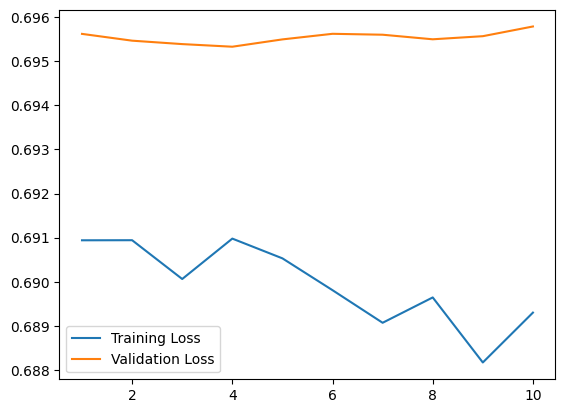

In [106]:
# Plot the losses

epochs = range(1, 11)
plt.plot(epochs, tr_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()

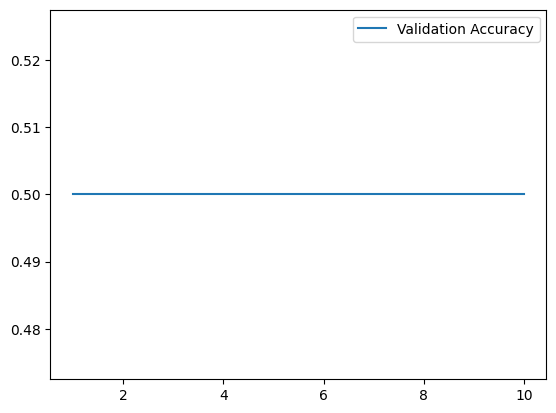

In [107]:
# Plot the validation accuracy

plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.show()


In [108]:
# Metrics

print("Accuracy Score:", accuracy_score(t, pr))
print("F1 Score:", f1_score(t, pr))
print("Precision Score:", precision_score(t, pr))
print("Recall Score:", recall_score(t, pr))


Accuracy Score: 0.5
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0


C:\Users\harin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

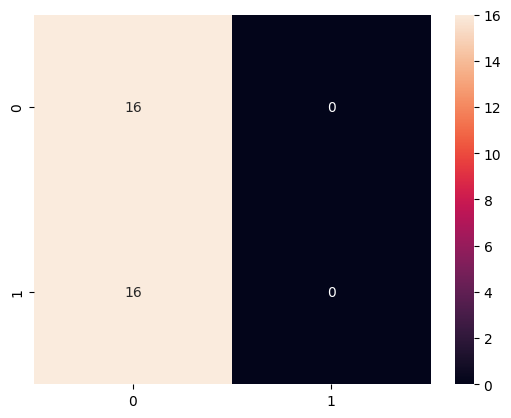

In [109]:
# Confusion Matrix

import seaborn as sns
cm = confusion_matrix(t, pr)
sns.heatmap(cm, annot=True, fmt="d")

### Loading the best model 1

In [110]:
# Initializing the model

model = MLP()
load(model, "best_checkpoint.json.gz")
model.to(device)

op = Adam(model.parameters(), lr=0.0001)

Checkpoint loaded from best_checkpoint.json.gz


In [111]:
imdb = pd.read_csv("IMDB.csv")
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [112]:
# Preparing the dataset

X, y = imdb["review"], imdb["sentiment"]

Y = y.map({"positive": 1, "negative": 0})

X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size=0.2, random_state=42)

X_val, X_t, Y_val, Y_t = train_test_split(X_t, Y_t, test_size=0.5, random_state=42)

In [113]:
print(X_tr.shape, X_val.shape, X_t.shape)

(40000,) (5000,) (5000,)


In [114]:
# Using the vectorizer

X_tr_v = vec.transform(X_tr)
X_val_v = vec.transform(X_val)
X_t_v = vec.transform(X_t)

X_tr_ten = torch.tensor(X_tr_v.toarray(), dtype=torch.float32).to(device)
X_val_ten = torch.tensor(X_val_v.toarray(), dtype=torch.float32).to(device)
X_t_ten = torch.tensor(X_t_v.toarray(), dtype=torch.float32).to(device)

Y_tr_ten = torch.tensor(Y_tr.to_numpy(), dtype=torch.long).to(device)
Y_val_ten = torch.tensor(Y_val.to_numpy(), dtype=torch.long).to(device)
Y_t_ten = torch.tensor(Y_t.to_numpy(), dtype=torch.long).to(device)

print(X_tr_ten.shape, X_val_ten.shape, X_t_ten.shape)

torch.Size([40000, 10000]) torch.Size([5000, 10000]) torch.Size([5000, 10000])


In [115]:
# Datasets

tr_data = TensorDataset(X_tr_ten, Y_tr_ten)
val_data = TensorDataset(X_val_ten, Y_val_ten)
t_data = TensorDataset(X_t_ten, Y_t_ten)

tr_load = DataLoader(tr_data, batch_size=32, shuffle=True)
val_load = DataLoader(val_data, batch_size=32, shuffle=False)
t_load = DataLoader(t_data, batch_size=32, shuffle=False)


In [116]:
# Training the model

best_acc = float(0)
tr_loss = []
val_loss = []
val_acc = []

writer = SummaryWriter()

for e in range(10): 
    model.train()
    loss = 0

    for X_b, Y_b in tqdm(tr_load, desc="Epoch " + str(e + 1) + " Training"):
        op.zero_grad()
        out = model(X_b)
        loss_ = criterion(out, Y_b)
        loss_.backward()
        op.step()
        loss += loss_.item()

    loss /= len(tr_load)
    tr_loss.append(loss)

    model.eval()

    v_loss = 0.0

    pr, t = [], []

    with torch.no_grad():

        for X_b, Y_b in tqdm(val_load, desc="Epoch " + str(e + 1) + " Validation"):
            out = model(X_b)
            v_loss_ = criterion(out, Y_b)
            v_loss += v_loss_.item()

            pr.extend(torch.argmax(out, 1).cpu().numpy())
            t.extend(Y_b.cpu().numpy())

    v_loss /= len(val_load)
    val_loss.append(v_loss)

    val_acc_ = accuracy_score(t, pr)

    val_acc.append(val_acc_)

    print("Epoch", e + 1, "Training Loss", loss, "Validation Loss", v_loss, "Validation Accuracy", val_acc_)

    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(str(name)+"/weights", param.data, e)
            writer.add_histogram(str(name)+"/grad", param.grad, e)
writer.close()

Epoch 1 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.4834136641383171 Validation Loss 0.27655746892189526 Validation Accuracy 0.8912


Epoch 2 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.23631313167214393 Validation Loss 0.25703510808147445 Validation Accuracy 0.895


Epoch 3 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.16621420953422786 Validation Loss 0.28721269888055934 Validation Accuracy 0.8914


Epoch 4 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.09060293928049505 Validation Loss 0.3857053003576436 Validation Accuracy 0.882


Epoch 5 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 Training Loss 0.04499585728188977 Validation Loss 0.4281211004141647 Validation Accuracy 0.8872


Epoch 6 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 Training Loss 0.02907130865768995 Validation Loss 0.477604986945535 Validation Accuracy 0.879


Epoch 7 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 Training Loss 0.022095365169423165 Validation Loss 0.5478613762152351 Validation Accuracy 0.8864


Epoch 8 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 Training Loss 0.018309372275997885 Validation Loss 0.5606993553265751 Validation Accuracy 0.8828


Epoch 9 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 Training Loss 0.0114825081418443 Validation Loss 0.6559044367090241 Validation Accuracy 0.8798


Epoch 10 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 Training Loss 0.011904875891975825 Validation Loss 0.6371439734338872 Validation Accuracy 0.8828


In [117]:
# Tensorboard

tensorboard.notebook.start("--logdir runs --port 6009")

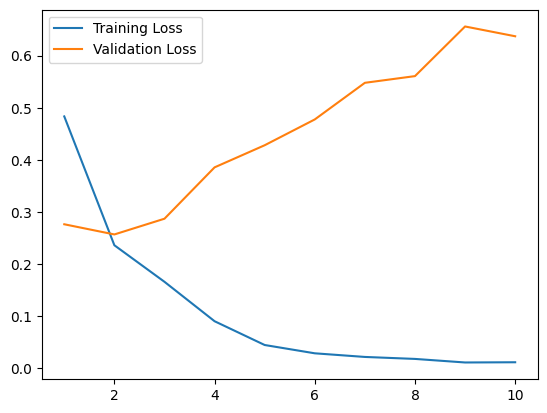

In [118]:
# Plotting the losses

epochs = range(1, 11)

plt.plot(epochs, tr_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()

plt.show()

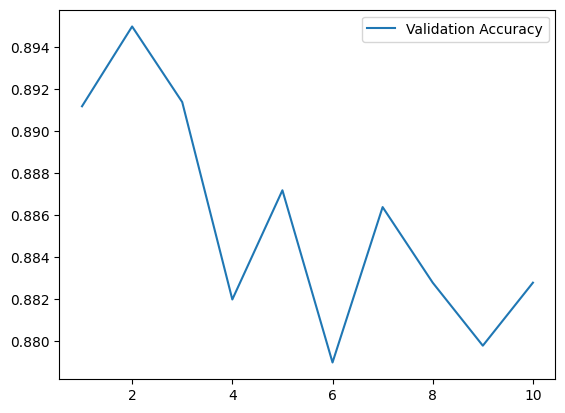

In [119]:
# Plotting the validation accuracy

plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.show()

In [120]:
# Metrics

print("Accuracy Score:", accuracy_score(t, pr))
print("F1 Score:", f1_score(t, pr))
print("Precision Score:", precision_score(t, pr))
print("Recall Score:", recall_score(t, pr))


Accuracy Score: 0.8828
F1 Score: 0.8804081632653061
Precision Score: 0.8991246352646937
Recall Score: 0.8624550179928029


<Axes: >

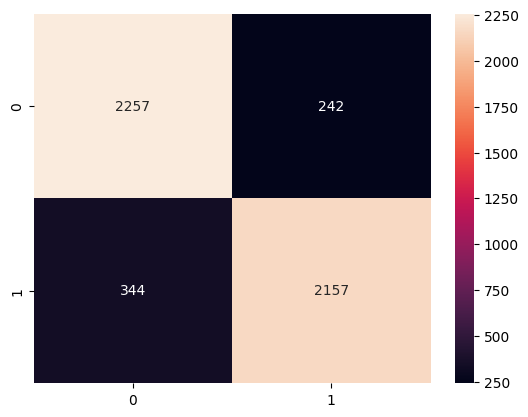

In [121]:
# Confusion Matrix

import seaborn as sns
cm = confusion_matrix(t, pr)

sns.heatmap(cm, annot=True, fmt="d")

In [126]:
# Embeddings

X_tr_txt = X_tr.to_list()
X_val_txt = X_val.to_list()
X_t_txt = X_t.to_list()

X_tr_txt = [X_tr_txt[i] for i in random.sample(range(0, len(X_tr_txt)), 160)]
X_val_txt = [X_val_txt[i] for i in random.sample(range(0, len(X_val_txt)), 32)]
X_t_txt = [X_t_txt[i] for i in random.sample(range(0, len(X_t_txt)), 32)]

X_tr_ten = []
X_val_ten = []
X_t_ten = []

for i in tqdm(X_tr_txt, desc="Embedding Training"):
    X_tr_ten.append(torch.tensor(bert_embed(i)).to(device))

for i in tqdm(X_val_txt, desc="Embedding Validation"):
    X_val_ten.append(torch.tensor(bert_embed(i)).to(device))

for i in tqdm(X_t_txt, desc="Embedding Testing"):
    X_t_ten.append(torch.tensor(bert_embed(i)).to(device))
    


Embedding Training:   0%|          | 0/160 [00:00<?, ?it/s]

C:\Users\harin\AppData\Local\Temp\ipykernel_17192\181256285.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tr_ten.append(torch.tensor(bert_embed(i)).to(device))


Embedding Validation:   0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\harin\AppData\Local\Temp\ipykernel_17192\181256285.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_ten.append(torch.tensor(bert_embed(i)).to(device))


Embedding Testing:   0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\harin\AppData\Local\Temp\ipykernel_17192\181256285.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t_ten.append(torch.tensor(bert_embed(i)).to(device))


In [127]:
# Tensors

X_tr_ten = torch.cat(X_tr_ten, 0)
X_val_ten = torch.cat(X_val_ten, 0)
X_t_ten = torch.cat(X_t_ten, 0)

y_tr_ten = [Y_tr.to_numpy()[i] for i in random.sample(range(0, len(Y_tr)), 160)]
y_val_ten = [Y_val.to_numpy()[i] for i in random.sample(range(0, len(Y_val)), 32)]
y_t_ten = [Y_t.to_numpy()[i] for i in random.sample(range(0, len(Y_t)), 32)]

y_tr_ten = torch.tensor(y_tr_ten, dtype=torch.long).to(device)
y_val_ten = torch.tensor(y_val_ten, dtype=torch.long).to(device)
y_t_ten = torch.tensor(y_t_ten, dtype=torch.long).to(device)

print(X_tr_ten.shape, X_val_ten.shape, X_t_ten.shape, y_tr_ten.shape, y_val_ten.shape, y_t_ten.shape)



torch.Size([160, 768]) torch.Size([32, 768]) torch.Size([32, 768]) torch.Size([160]) torch.Size([32]) torch.Size([32])


In [128]:
# Datasets

tr_data = TensorDataset(X_tr_ten, y_tr_ten)
val_data = TensorDataset(X_val_ten, y_val_ten)
t_data = TensorDataset(X_t_ten, y_t_ten)

tr_load = DataLoader(tr_data, batch_size=32, shuffle=True)
val_load = DataLoader(val_data, batch_size=32, shuffle=False)
t_load = DataLoader(t_data, batch_size=32, shuffle=False)


In [129]:
# Initializing model using best Model 2

model_ = MLP_().to(device)
load(model_, "2_best_checkpoint.json.gz")
model_.to(device)

op = Adam(model_.parameters(), lr=0.0001)


Checkpoint loaded from 2_best_checkpoint.json.gz


In [130]:
# Model Training

best_acc = float(0)
tr_loss = []
val_loss = []
val_acc = []

writer = SummaryWriter()

for e in range(10):

    model_.train()
    loss = 0

    for X_b, Y_b in tqdm(tr_load, desc="Epoch " + str(e + 1) + " Training"):
        op.zero_grad()
        out = model_(X_b)
        loss_ = criterion(out, Y_b)
        loss_.backward()
        op.step()
        loss += loss_.item()

    loss /= len(tr_load)

    tr_loss.append(loss)

    model_.eval()

    v_loss = 0.0

    pr, t = [], []

    with torch.no_grad():
        for X_b, Y_b in tqdm(val_load, desc="Epoch " + str(e + 1) + " Validation"):
            out = model_(X_b)
            v_loss_ = criterion(out, Y_b)
            v_loss += v_loss_.item()

            pr.extend(torch.argmax(out, 1).cpu().numpy())
            t.extend(Y_b.cpu().numpy())
    
    v_loss /= len(val_load)
    val_loss.append(v_loss)

    val_acc_ = accuracy_score(t, pr)
    val_acc.append(val_acc_)

    print("Epoch", e + 1, "Training Loss", loss, "Validation Loss", v_loss, "Validation Accuracy", val_acc_)

    for name, param in model_.named_parameters():
        if param.requires_grad:
            writer.add_histogram(str(name)+"/weights", param.data, e)
            writer.add_histogram(str(name)+"/grad", param.grad, e)

writer.close()

Epoch 1 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.697314727306366 Validation Loss 0.678505539894104 Validation Accuracy 0.625


Epoch 2 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.6955105304718018 Validation Loss 0.678753137588501 Validation Accuracy 0.625


Epoch 3 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.6961224198341369 Validation Loss 0.6794660687446594 Validation Accuracy 0.625


Epoch 4 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.6961287379264831 Validation Loss 0.6805287599563599 Validation Accuracy 0.625


Epoch 5 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 Training Loss 0.6954767227172851 Validation Loss 0.6813626885414124 Validation Accuracy 0.625


Epoch 6 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 Training Loss 0.6948786616325379 Validation Loss 0.6820771098136902 Validation Accuracy 0.625


Epoch 7 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 Training Loss 0.6940413594245911 Validation Loss 0.6828455924987793 Validation Accuracy 0.625


Epoch 8 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 Training Loss 0.695029103755951 Validation Loss 0.683784544467926 Validation Accuracy 0.625


Epoch 9 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 Training Loss 0.6939526796340942 Validation Loss 0.6844648718833923 Validation Accuracy 0.625


Epoch 10 Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 Training Loss 0.6932425260543823 Validation Loss 0.685064435005188 Validation Accuracy 0.625


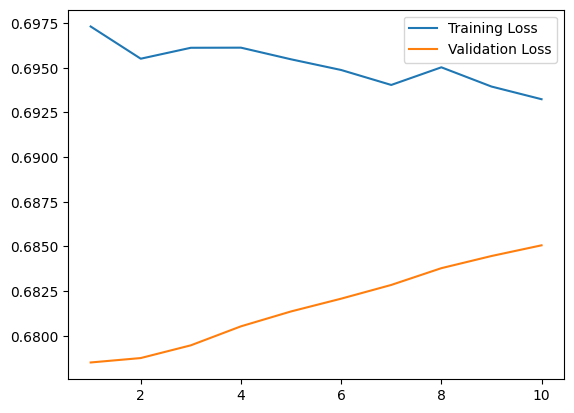

In [131]:
# Plotting the losses

epochs = range(1, 11)
plt.plot(epochs, tr_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()


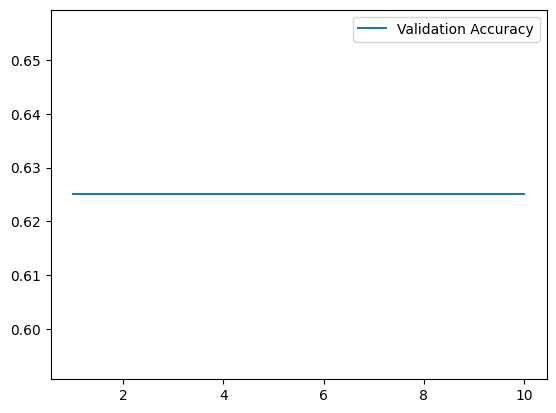

In [132]:
# Plotting the validation accuracy

plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.show()


In [133]:
# Metrics

print("Accuracy Score:", accuracy_score(t, pr))
print("F1 Score:", f1_score(t, pr))
print("Precision Score:", precision_score(t, pr))
print("Recall Score:", recall_score(t, pr))


Accuracy Score: 0.625
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0


C:\Users\harin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

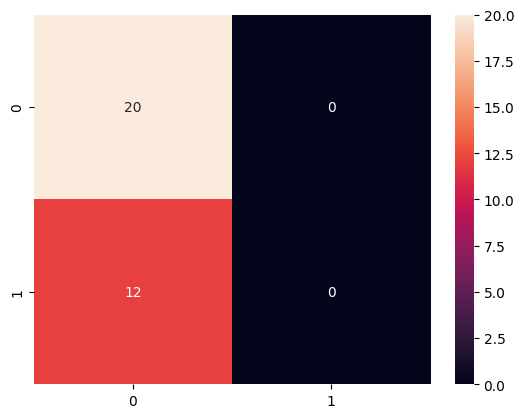

In [134]:
# Confusion Matrix

cm = confusion_matrix(t, pr)
sns.heatmap(cm, annot=True, fmt="d")

In [135]:
# Tensorboard

tensorboard.notebook.start("--logdir runs --port 6010")